# Advanced Statistical Inference -- Bayesian Linear Regression

In this session, you'll start to implement some basic Bayesian models, 
starting from the simple Bayesian linear regression.

In [1]:
import functools
import warnings

import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.stats
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D

preamble = r"""\renewcommand{\familydefault}{\sfdefault}
            \usepackage{sansmath} \sansmath  \usepackage{amsmath}"""
rc("font", **{"family": "sans-serif", "sans-serif": "DejaVu Sans"})
rc("text", **{"usetex": False, "latex.preamble": preamble})
rc("figure", **{"dpi": 200})
rc(
    "axes",
    **{"spines.right": False, "spines.top": False, "xmargin": 0, "ymargin": 0.05}
)

## 1. A regression dataset
Create a simple 1D regression dataset using the `make_regression(...)` function and plot it.
For the moment, keep the noise variance $\sigma_\mathrm{n}$ small.
NB. For better reproducibility, please remember to fix the Numpy's random seed. 
For Jupyter notebooks, this needs to be done at the beginning of all cells.

In [2]:
true_function = lambda x: 0.5 * ((x - 1) ** 2) - 3


def make_regression(n, sn2=0.1):
    x = np.random.uniform(-3, 3, n)
    y = true_function(x) + np.sqrt(sn2) * np.random.randn(*x.shape)
    return x, y

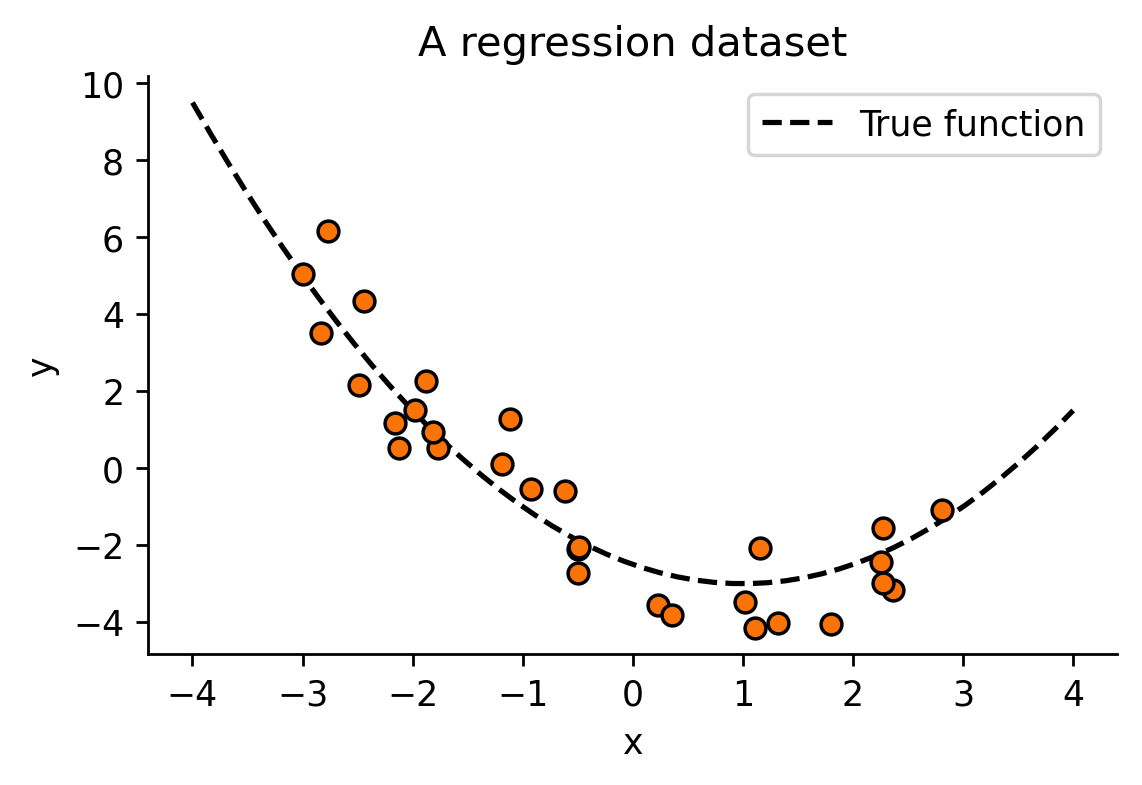

In [3]:
np.random.seed(1)
sn2 = 1.5
x, y = make_regression(30, sn2=sn2)
xp = np.linspace(-4, 4)

fig, ax = plt.subplots(figsize=[5, 3], dpi=250)
ax.plot(xp, true_function(xp), "--k", zorder=0, label="True function")
ax.scatter(x, y, edgecolor="black", linewidth=1, facecolor="xkcd:orange")
ax.set_title("A regression dataset")
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.margins(0.05)
plt.show()

## 2. A review on Gaussian likelihood
Let's start from the basics. Remember what a likelihood is.
The **likelihood** measures the goodness of fit of a statistical model to samples of data for given values of 
the unknown model parameters.
It's computed from the joint probability distribution, but viewed and used as **function** 
of the parameters only, thus treating the random variables as fixed at the observed values.

A Gaussian likelihood is defined as 

\begin{equation}
p(\mathbf{y}|\mathbf{w}, \mathbf{X}, \sigma_\mathrm{n}) = \prod_{i=1}^N p(y_i|\mathbf{w}, {\mathbf{x}}_i, \sigma_\mathrm{n}) = \prod_{i=1}^N \mathcal{N}(y_i|\tilde y_i, \sigma_\mathrm{n})
\end{equation}

where, for linear regression, $\tilde y_i = \mathbf{w}^\top {\mathbf{x}}_i$.
For numerical stability, instead of using the vanilla likelihood, we will use the **log-likelihood**.

\begin{equation}
\log p(\mathbf{y}|\mathbf{w}, \mathbf{X}, \sigma_\mathrm{n}) =  \sum_{i=1}^N  \log\mathcal{N}(y_i|\tilde y_i, \sigma_\mathrm{n})
\end{equation}

**Exercise:**
Write a function to compute the log-density of a normal distribution at position $x$, given $\mu$ and $\sigma^2$.

In [5]:
def lognormal(x, mu, var):
    # @@ COMPLETE @@ #
    return - 0.5 * (np.log(var) + np.log(2*np.pi) + (x - mu) ** 2 / var)

**Exercise:**
For the moment, assume that for the sample $i^{\mathrm{th}}$, you predict $\tilde y = 0.3$ and $\sigma_\mathrm{n} = 1$. 
You know that $y = 0.4$. 
Complete the following function `gaussian_loglik(...)`, then compute the (log)likelihood for this sample and show its position on the Gaussian density with a plot.

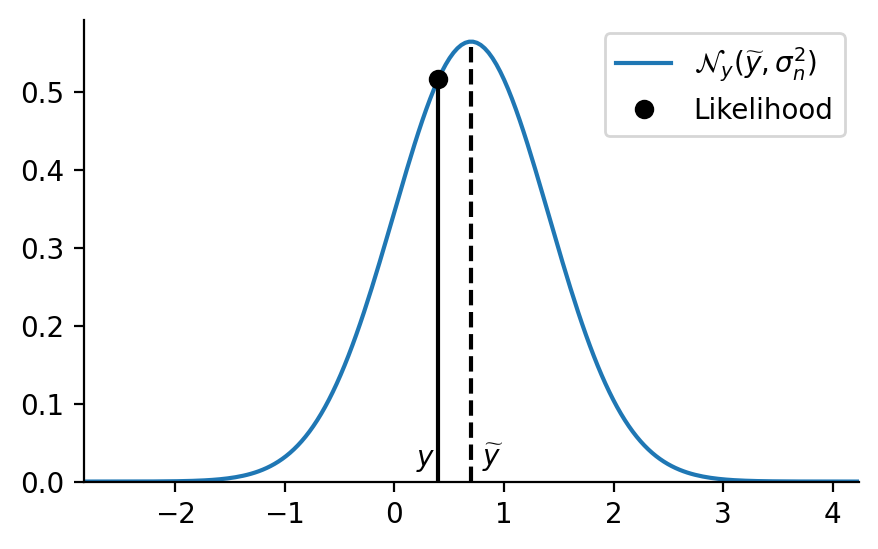

In [7]:
def gaussian_loglik(y, y_tilde, sn2):
    # @@ COMPLETE @@ #
    # Simply return a normal distribution of mean y_tilde and variance sn2

    return lognormal(y, y_tilde, sn2)


def plot_gaussian(mu, var, plot_log=False, **kwargs):
    """A simple util to plot a gaussian pdf"""
    x = np.linspace(mu - 5 * np.sqrt(var), mu + 5 * np.sqrt(var), 200)
    y = lognormal(x, mu, var) if plot_log else np.exp(lognormal(x, mu, var))
    ax = kwargs.pop("ax", plt.gca())
    ax.plot(x, y, **kwargs)
    return ax

# Inserting random numbers just to show what the plot will be
y_obs =  0.4 # @@ COMPLETE @@ #
y_tilde = 0.7  # @@ COMPLETE @@ #
sn2 =  0.5 # @@ COMPLETE @@ #
sample_ll = gaussian_loglik(y_obs, y_tilde, sn2) # @@ COMPLETE @@ #

fig, ax = plt.subplots(figsize=[5, 3])
plot_gaussian(y_tilde, sn2, ax=ax, label=r"$\mathcal{N}_y(\widetilde{y}, \sigma_n^2)$")
ax.vlines(y_obs, 0, np.exp(sample_ll), color="k")
ax.vlines(
    y_tilde, 0, np.exp(gaussian_loglik(y_tilde, y_tilde, sn2)), ls="--", color="k"
)
ax.plot(y_obs, np.exp(sample_ll), "ok", label=r"Likelihood")
ax.text(y_tilde + 0.1, 0.02, r"$\widetilde{y}$")
ax.text(y_obs - 0.2, 0.02, r"$y$")
ax.set_ylim(0)
ax.legend()
plt.show()

## 3. Bayesian Linear regression

In this section, you'll start to implement the Bayesian linear regression model.
Let's start by creating the **design matrix** $\mathbf{X}$.

$$
\mathbf{X} = \left[ {\begin{array}{ccccc}
   1 & x_1^1 & \dots & x_1^K\\
   1 & x_2^1 & \dots & x_2^K\\
   \vdots &    \vdots & &   \vdots \\
   1 & x_N^1 & \dots & x_N^K\\
  \end{array} } \right]
$$

**Exercise:**
Complete the following function `build_features(...)` to build $\mathbf{X}$.
This can be done in many ways. One of them is using a double list comprehension (one index for the row and one for the column), while another one is using the numpy `column_stack()` function (highly suggested). In any case, inspect $\mathbf{X}$ to make sure it looks OK (show the first entries). To fit higher order polynomials, we need to add extra columns to $\mathbf{X}$, therefore build it with $K$ as a parameter.

In [8]:
def build_features(x, K):
    # @@ COMPLETE @@ #
    X_ = [x**k for k in range(K+1)]

    return np.column_stack(X_)

In [9]:
build_features(x, 2)

array([[ 1.        , -0.49786797,  0.24787252],
       [ 1.        ,  1.32194696,  1.74754377],
       [ 1.        , -2.99931375,  8.99588298],
       [ 1.        , -1.18600456,  1.40660683],
       [ 1.        , -2.11946466,  4.49213042],
       [ 1.        , -2.44596843,  5.98276157],
       [ 1.        , -1.88243873,  3.54357558],
       [ 1.        , -0.92663564,  0.85865361],
       [ 1.        , -0.61939515,  0.38365036],
       [ 1.        ,  0.2329004 ,  0.0542426 ],
       [ 1.        , -0.48483291,  0.23506295],
       [ 1.        ,  1.111317  ,  1.23502548],
       [ 1.        , -1.7732865 ,  3.14454502],
       [ 1.        ,  2.26870462,  5.14702065],
       [ 1.        , -2.83567444,  8.04104953],
       [ 1.        ,  1.02280506,  1.04613019],
       [ 1.        , -0.49617119,  0.24618585],
       [ 1.        ,  0.35213897,  0.12400185],
       [ 1.        , -2.15767837,  4.65557594],
       [ 1.        , -1.81139107,  3.28113759],
       [ 1.        ,  1.80446741,  3.256

From the lecture notes, let's define the prior on the parameters $\mathbf{w}$ as 

\begin{equation}
\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \mathbf{S}) 
\end{equation}

For sake of simplicity, assume the covariance matrix $\mathbf{S}$ to be diagonal $\mathbf{S} = \sigma_\mathrm{w}^2\mathbf{I}$.
Remember that the likelihood is defined as $p(\mathbf{y}|\mathbf{w}, \mathbf{X}, \sigma_\mathrm{n}) = \mathcal{N}(\mathbf{y}|\mathbf{X}\mathbf{w}, \sigma_\mathrm{n}^2\mathbf{I})$.
In this case, the posterior is analitic and follows this form:

\begin{equation}
p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n}) = \mathcal{N}\left(\frac{1}{\sigma^2_\mathrm{n}}\mathbf{\Sigma}\mathbf{X}^\top\mathbf{y}, \mathbf{\Sigma} \right)
\end{equation}
where $\mathbf{\Sigma}^{-1} = \left(\frac{1}{\sigma^2_\mathrm{n}}\mathbf{X}^\top\mathbf{X} + \mathbf{S}^{-1}  \right)$.

**Question:** What is the dimensionality of $\mathbf{\Sigma}$? How much does it cost to compute that inverse? Do you know which algorithm you should use to have numerically stable results? Remember that computing $\mathbf{A}^{-1}\mathbf{z}$ means in practice solving a linear system.

**Exercise:** Complete the following function to compute the posterior.

**Question Answer**:
The dimensionality of $\Sigma$ is (D,D). The cost of the inversion is directly correlated to the dimentionality of our data; the bigger the data, the more expensive becomes the inversion. Some good methods to perform this operation might be decompositions operations like: QR, Cholesky, LU.

**Exercise Answer**:

In [10]:
def compute_posterior(X, y, sw2, sn2):
    # @@ COMPLETE @@ #
    Sigma_inverse = 1 / sn2 * X.T @ X + (1/sw2) * np.eye(X.shape[1])
    Sigma = np.linalg.inv(Sigma_inverse)
    posterior_mu = 1 / sn2 * Sigma @ X.T @ y
    return posterior_mu, Sigma

**Execise:** Compute the posterior for the regression dataset. For the moment, place $\sigma_\mathrm{w}^2=1$ and start with polynomial of order 1. Finally, print the posterior mean and covariance. Comment the results.

In [11]:
sw2 = 1
K = 1

X = build_features(x, K)

w_posterior_mean, w_posterior_cov = compute_posterior(X, y, sw2, sn2)

In [12]:
print(w_posterior_mean)

[-0.97400921 -1.28366202]


In [13]:
print(w_posterior_cov)

[[0.01713164 0.00193771]
 [0.00193771 0.00508635]]


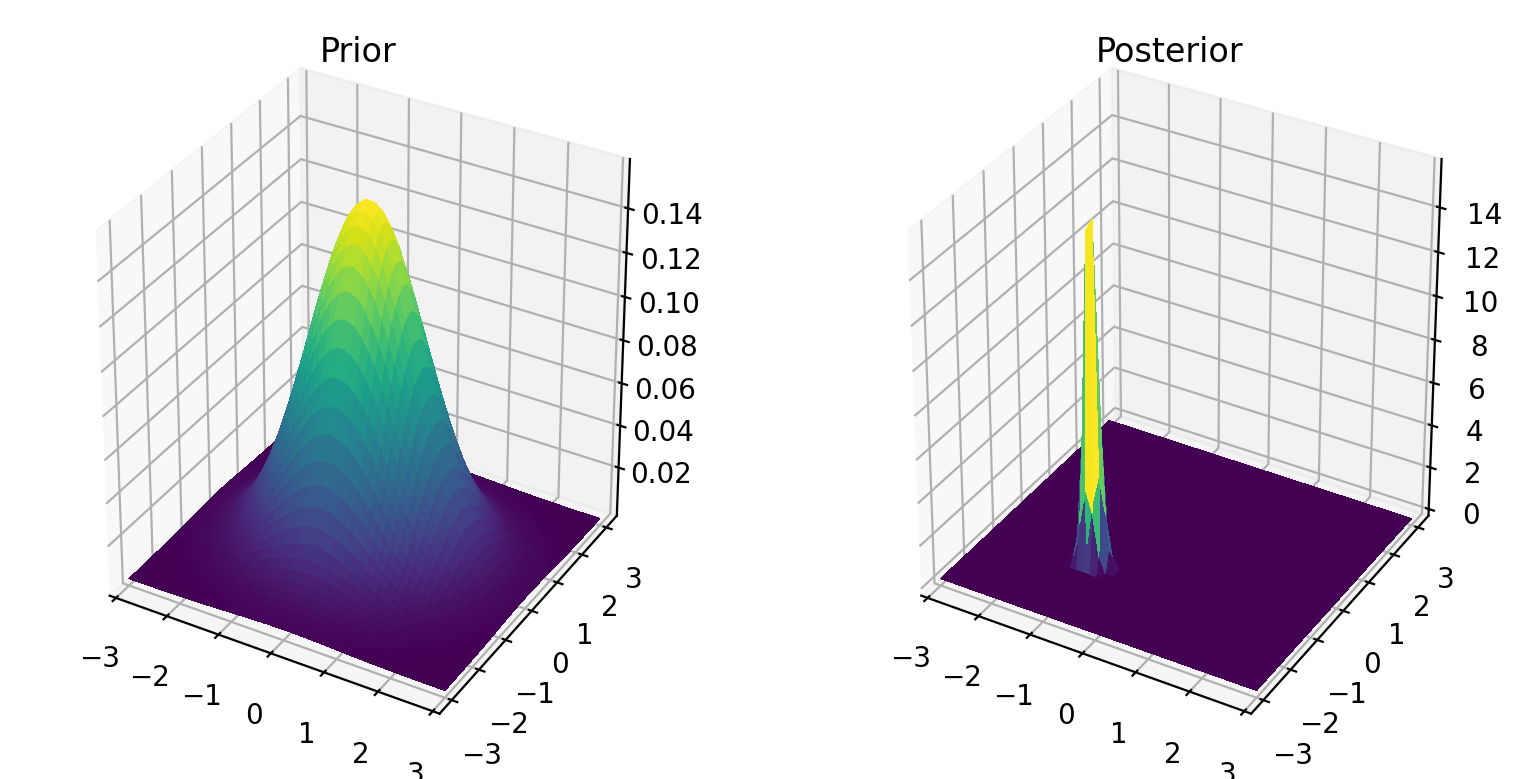

In [14]:
x_ = np.linspace(-3, 3, 50)
y_ = np.linspace(-3, 3, 50)
X_, Y_ = np.meshgrid(x_, y_)
pos = np.empty(X_.shape + (2,))
pos[:, :, 0] = X_
pos[:, :, 1] = Y_


fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection="3d")

rv = scipy.stats.multivariate_normal(np.zeros(2), sw2 * np.eye(2))
plot_config = dict(
    cmap="viridis", linewidth=0, antialiased=False, ccount=500, rcount=500
)
ax.plot_surface(X_, Y_, rv.pdf(pos), **plot_config)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_title("Prior")

ax = fig.add_subplot(1, 2, 2, projection="3d")
rv = scipy.stats.multivariate_normal(w_posterior_mean, w_posterior_cov)
ax.plot_surface(X_, Y_, rv.pdf(pos), **plot_config)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")

ax.set_title("Posterior")
plt.show()

**Question Answer**: As we can see from the obtained plots, adding observations, through the likelihood, to our priors helps us to obtain a more skewed distributions on our parameter. Looking at the prior we knew that:
\begin{equation}
\mathbf{\mu} = \left[ {\begin{array}{cc}
   0 \\
   0 \\
  \end{array} } \right], \mathbf{S} = \left[ {\begin{array}{ccc}
   1 & 0 \\
   0 & 1 \\
  \end{array} } \right]
\end{equation}
Hence a wider range of parameters is possible. When instead looking at out posterior distribution parameters:
\begin{equation}
\mathbf{\mu} = \left[ {\begin{array}{cc}
   -0.974 \\
   -1.284 \\
  \end{array} } \right], \mathbf{S} = \left[ {\begin{array}{ccc}
   0.017 & 0.002 \\
   0.002 & 0.005 \\
  \end{array} } \right]
\end{equation}
From those parameters we can see that our parameter choice is easier, given the very low posterior variance.

## 4. Predictions
Now it's time to make predictions. 
All our motivation for being Bayesian was to be able to average predictions at $\mathbf{x}_\mathrm{new}$, for all possible $\mathbf{w}$.
This is possible by computing the following expectation:


\begin{equation}
\mathbf{E}_{p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n})}\mathcal{N}(\mathbf{w}^\top\mathbf{x}_\mathrm{new}, \sigma^2_\mathrm{n}) = \int \mathcal{N}(\mathbf{w}^\top\mathbf{x}_\mathrm{new}, \sigma^2_\mathrm{n}) p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n}) \mathrm{d}\mathbf{w}
\end{equation}


**Question:** Prove that 
$\mathbf{E}_{p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n})}\mathcal{N}(\mathbf{w}^\top\mathbf{x}_\mathrm{new}, \sigma^2_\mathrm{n}) = 
\mathcal{N}(\mathbf{x}_\mathrm{new}^\top\mathbf{\mu}, \sigma^2_\mathrm{n} + \mathbf{x}_\mathrm{new}^\top\mathbf{\Sigma}\mathbf{x}_\mathrm{new})$, where $\mathbf{\mu}$ and $\mathbf{\Sigma}$ are the posterior mean and covariance.

**Exercise:** 
Write a function to compute the predictive distribution. 
Usually we want to do this for multiple points, hence the for-loop.

In [15]:
def compute_predictive(Xt, w_mean, w_cov, sn2):
    def _compute_predictive_single_point(xt_i, w_mean, w_cov, sn2):
        yt_i_mean = xt_i.T @ w_mean
        yt_i_var =  sn2 + xt_i.T @ w_cov @ xt_i
        return yt_i_mean, yt_i_var

    yt_mean, yt_var = np.zeros(len(Xt)), np.zeros(len(Xt))
    for i, xt_i in enumerate(Xt):  # Loop on all the points
        yt_mean[i], yt_var[i] = _compute_predictive_single_point(
            xt_i, w_mean, w_cov, sn2
        )

    return yt_mean, yt_var

**Exercise:** Compute and plot the predictive distribution for 100 points between -4 and +4.

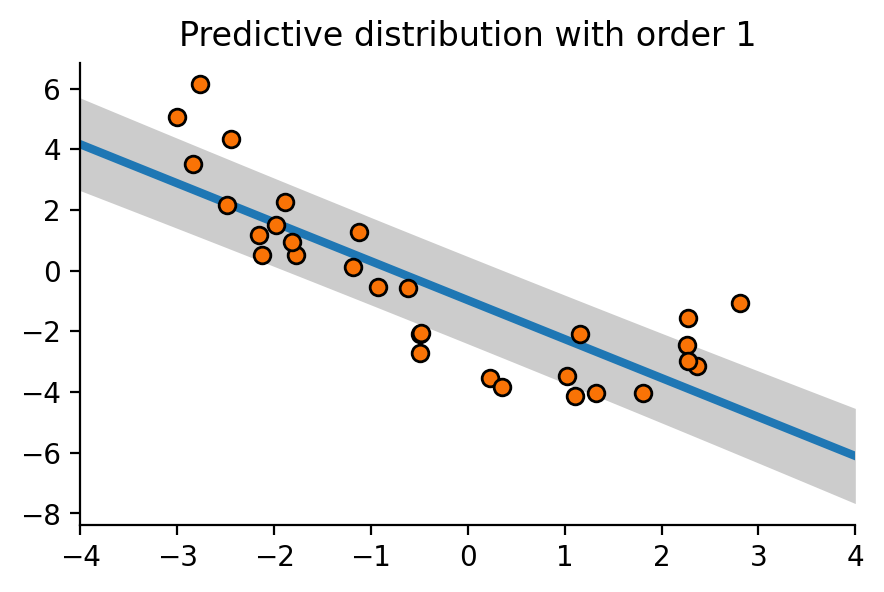

In [17]:
xt = np.linspace(-4, 4, 250)
Xt = build_features(xt, K)
y_mean, y_var = compute_predictive(Xt, w_posterior_mean, w_posterior_cov, sn2)


fig, ax = plt.subplots(figsize=[5, 3])
ax.scatter(x, y, edgecolor="black", linewidth=1, facecolor="xkcd:orange", zorder=10)
ax.plot(xt, y_mean, color="tab:blue", lw=3)

lb = y_mean - 2 * np.sqrt(y_var)
ub = y_mean + 2 * np.sqrt(y_var)
ax.fill_between(xt, lb, ub, color=".80", lw=0)
ax.set_title(f"Predictive distribution with order {K}")
plt.show()

**Exercise:** You can also sample from the posterior and compute the function values. A simple way to do so is to sample from the posterior on the weights and then from the noise model (in our case, its $\mathcal{N}(0, \sigma_n^2)$.
Complete and use the utility function below: sample 30 times the predictive posterior and plot it. 


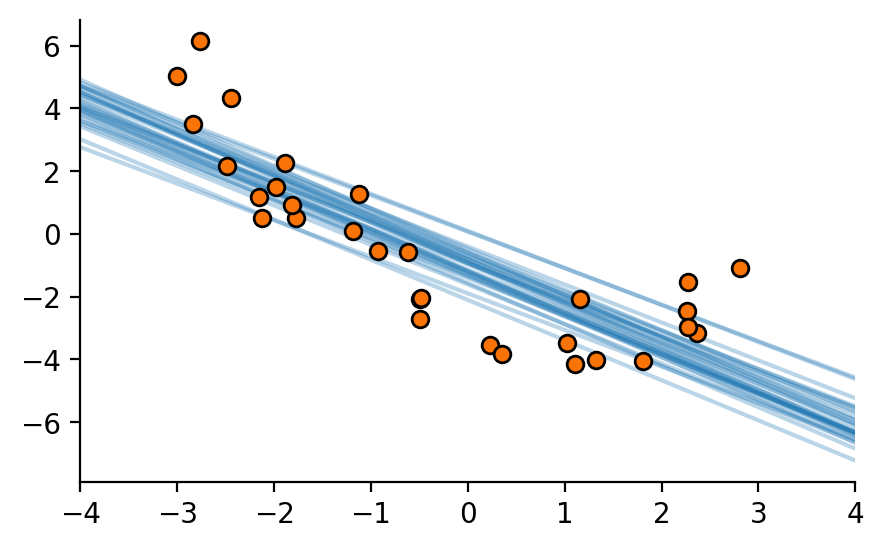

In [18]:
def sample(Xt, w_mean, w_cov, sn2, N):
    def _sample_single(Xt, w_mean, w_cov, sn2):
        # @@ COMPLETE @@ #
        w_sample = np.random.multivariate_normal(w_mean, w_cov)
        y_sample = Xt @ w_sample + np.random.normal(0, sn2)
        return y_sample

    samples = np.zeros((N, len(Xt)))
    for i in range(N):
        samples[i] = _sample_single(Xt, w_mean, w_cov, sn2)
    return samples


samples = sample(Xt, w_posterior_mean, w_posterior_cov, sn2, N=30)
fig, ax = plt.subplots(figsize=[5, 3])
ax.scatter(x, y, edgecolor="black", linewidth=1, facecolor="xkcd:orange", zorder=10)
ax.plot(xt, samples.T, "tab:blue", alpha=0.3)
plt.show()

**Exercise**: Try now with different polynomial order. Let's say 2, 5, 10, 15. Compute the design matrix, the posterior on $\mathbf{w}$ and the predictive posterior. What do you observe?

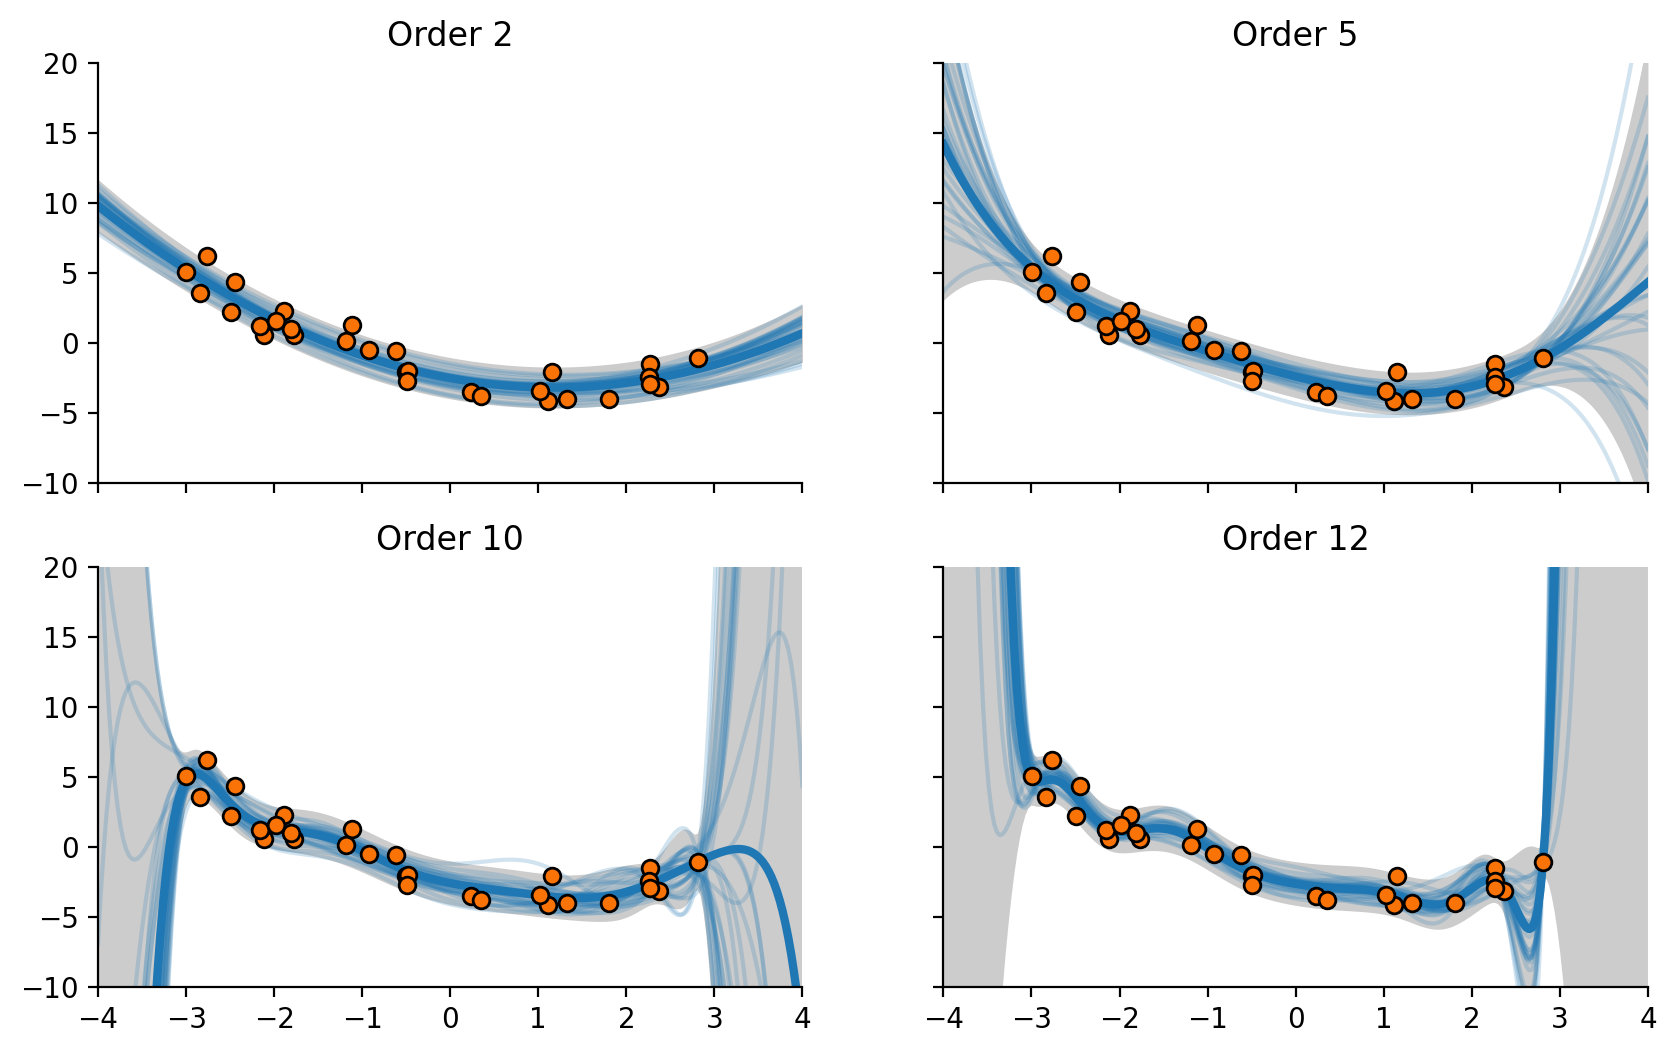

In [19]:
def bayesian_linear_regression(x, y, xt, K, sn2, sw2):
    X = build_features(x, K) 
    Xt = build_features(xt, K)  
    w_posterior_mean, w_posterior_cov =  compute_posterior(X, y, sw2, sn2)
    y_mean, y_var =  compute_predictive(Xt, w_posterior_mean, w_posterior_cov, sn2)
    samples =  sample(Xt, w_posterior_mean, w_posterior_cov, sn2, N=30)
    return y_mean, y_var, samples


poly_orders = [2, 5, 10, 12]

fig, axs = plt.subplots(2, 2, figsize=[10, 6], sharex=True, sharey=True)
axs = axs.reshape(-1)
for ax, K in zip(axs, poly_orders):
    y_mean, y_var, samples = bayesian_linear_regression(x, y, xt, K, sn2, sw2)

    lb = y_mean - 2 * np.sqrt(y_var)
    ub = y_mean + 2 * np.sqrt(y_var)

    ax.fill_between(xt, lb, ub, color=".80", lw=0)
    ax.plot(xt, samples.T, "tab:blue", alpha=0.2)
    ax.plot(xt, y_mean, color="tab:blue", lw=3)
    ax.scatter(x, y, edgecolor="black", linewidth=1, facecolor="xkcd:orange", zorder=10)
    ax.set_ylim(-10, 20)
    ax.set_title("Order %d" % K)
plt.show()

**Observations**: As we can see from the obtained plots, the order which seems to have the best result is order 2 (as our data generation process). In all the other examples it's possible to see a high variance of the model, yealding very different result for each iteration. 

**Exercise**:
Play with the next cell and try to answer the following questions:
1. Set n=0; what is the plot showing?
2. Try to increase the number of points "observed"; what is happening to the posterior?
3. Try to increase the polynomial order; how are the functions behaving?

In [20]:
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive


def animate(n, K):
    y_mean, y_var, samples = bayesian_linear_regression(x[:n], y[:n], xt, K, sn2, sw2)
    fig, ax = plt.subplots(figsize=[5, 3])
    ax.scatter(
        x[:n], y[:n], edgecolor="black", linewidth=1, facecolor="xkcd:orange", zorder=10
    )
    ax.plot(xt, samples.T, "tab:blue", alpha=0.3)
    ax.set_ylim(-10, 20)
    plt.show()


interaction = interact(
    animate,
    n=widgets.IntSlider(min=0, max=len(x), step=1, value=0, continuous_update=False),
    K=widgets.IntSlider(min=0, max=10, step=1, value=1, continuous_update=False),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='n', max=30), IntSlider(value=1,…

**Question Answers**:
- Setting **$n=0$** provides no data to update the posterior, hence our parameter predictions will be solely based on the prior distribution. Random lines are in fact obtained.
- When providing more and more observed samples, we provide more knowledge to the model, which is then able to predict less randomly the parameters.
- When increasing the value of **$K$** we can see that the complexity of the model increases, bringing more variance in our predictions, worsening the stability of our model.

## 5. Evaluate your model: the marginal likelihood

There are several ways in which you can compute the goodness of your model. The first is the likelihood itself.

**Question:** Compute the loglikelihood for model with order from 0 to 7 and plot it. Comment the results.

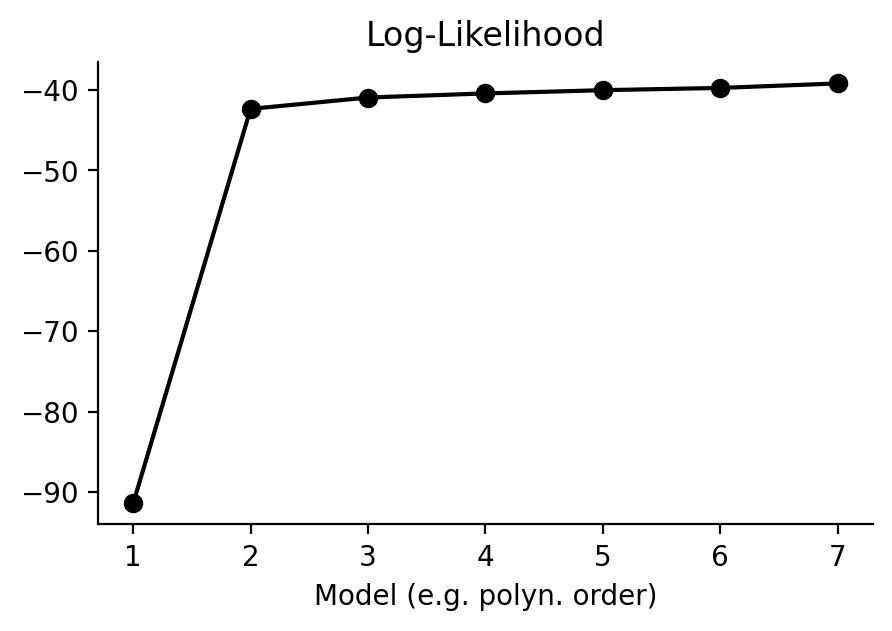

In [21]:
def evaluate_likelihood(x, y, K, sn2, sw2):
    y_mean, y_var, _ = bayesian_linear_regression(x, y, x, K, sn2, sw2)
    
    return np.sum(gaussian_loglik(y, y_mean, y_var))


Ks = np.arange(1, 8)
mll = [evaluate_likelihood(x, y, K, sn2, sw2) for K in Ks]

fig, ax = plt.subplots(figsize=[5, 3])
ax.plot(Ks, mll, "-ok")
ax.margins(0.05)
ax.set_title("Log-Likelihood")
ax.set_xlabel("Model (e.g. polyn. order)")

plt.show()

**Comments**: As expected higher degree models have a higher log-likelihood because the are able to fit our sample data well. The likelihood should not be used as a metric to pick the best model, because it does not take into account the variation of the model parameters $\omega$.

**Question:** Try to answer: How likely is $\mathbf{y}$ given $\mathbf{X}$ *and* the model (‘first/second/... order polynomial’)? Is it the same likelihood as before?

So far, we’ve ignored $p(\mathbf{y}|\mathbf{X}, \sigma^2_\mathrm{n})$, the normalising thing in Bayes rule. Being a normalization constant, it has to be equal to 

\begin{equation}
p(\mathbf{y}|\mathbf{X}, \sigma^2_\mathrm{n}) = \int p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma^2_\mathrm{n})
p(\mathbf{w})\mathrm{d}\mathbf{w}
\end{equation}

We’re averaging over all values of $\mathbf{w}$ to get a value for how good the model is.

**Question:** Suppose the prior being $\mathcal{N}(\mu_0, \mathbf{\Sigma}_0)$ and the likelihood $\mathcal{N}(\mathbf{X}\mathbf{w}, \sigma^2_\mathrm{n} \mathbf{I})$. Derive the marginal likelihood (hint: don't solve the integral -- check the rules for Gaussian conditioning and marginalization) (big hint: check the lecture notes).

**Exercise:** Write a function to compute the marginal likelihood. Remember: this is a *likelihood* not a density. You should return a number not a density. For simplicity, assume $\mu_0 = 0$ and $\Sigma_0 = \sigma^2_\mathrm{w}\mathbf{I}$. Use `scipy.stats.multivariate_normal` for computing the logpdf.

In [22]:
from scipy.stats import multivariate_normal

def marginal_likelihood(X, y, sw2, sn2):
    return  multivariate_normal.logpdf(y, np.zeros(len(y)), sn2 * np.eye(len(y)) + sw2 * X@X.T)

**Exercise:** Do the sample plot as before, but now plot the marginal likelihood. You should see a clear pattern here; comment the result.

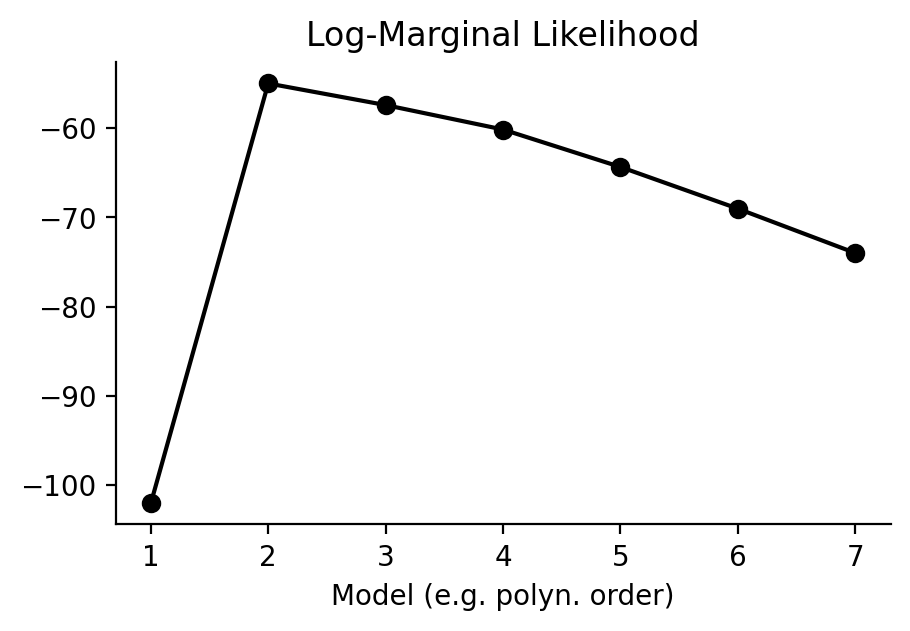

In [23]:
def evaluate_marginal_likelihood(x, y, K, sn2, sw2):
    X = build_features(x, K)
    return marginal_likelihood(X, y, sw2, sn2)


poly_orders = range(1, 8)
mll = [evaluate_marginal_likelihood(x, y, K, sn2, sw2) for K in poly_orders]

fig, ax = plt.subplots(figsize=[5, 3])
ax.plot(poly_orders, mll, "-ok")
ax.margins(0.05)

ax.set_title("Log-Marginal Likelihood")
ax.set_xlabel("Model (e.g. polyn. order)")
plt.show()

**Comments**: As we can see from the plot, the marginal likelihood is a much better metric to estimate model goodness. We can see that the peak value is reached when $K=2$, which is in fact the order of our true distribution. The values of marginal likelihood then decrease, due to the high variance obtained with higher degree models.  

## 6. When polynomial features are not enough (++)

In [24]:
import os
import urllib.request

from scipy.io import loadmat


def snelson1d(path):
    filename = os.path.join(os.path.expanduser(path), "snelson1d.mat")
    url = "https://github.com/markvdw/gp_upper/raw/master/notebooks/snelson1d.mat"

    if not os.path.exists(filename):
        print("Downloading from", url)
        urllib.request.urlretrieve(url, filename)

    data = loadmat(filename)
    idx = np.random.RandomState(0).permutation(len(data["X"]))[:75]

    return data["X"][idx, 0] - 3, data["Y"][idx, 0]


x, y = snelson1d("/tmp/")
xt = np.linspace(-6, 6, 200)
sn2 = 0.1

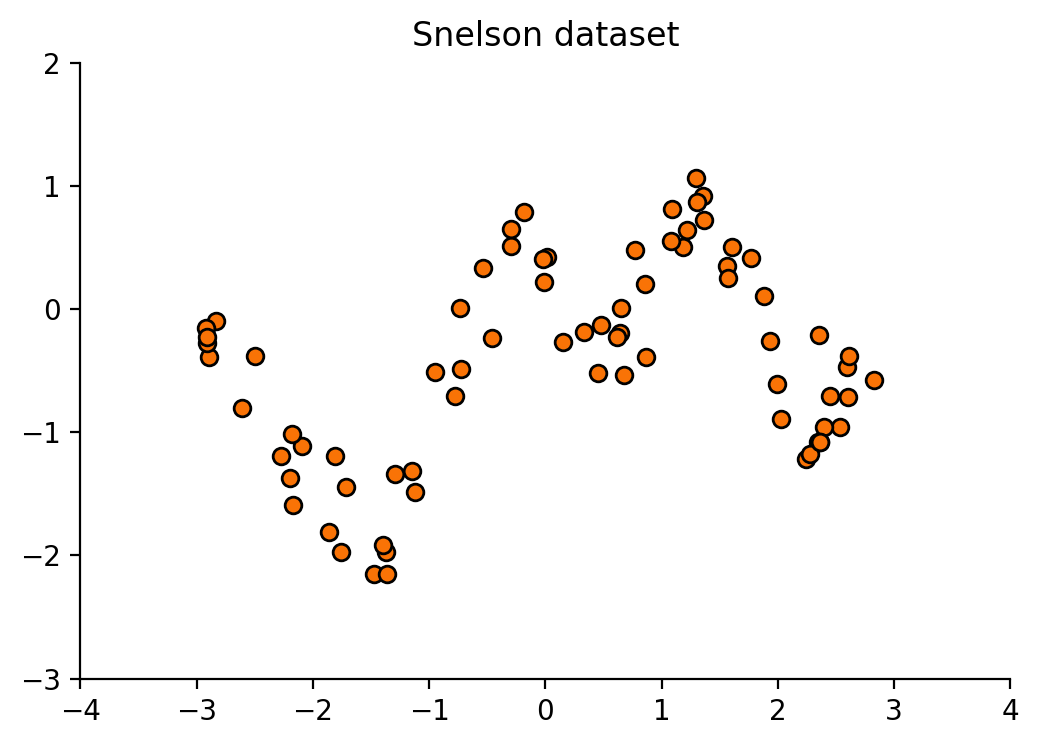

In [25]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.scatter(x, y, edgecolor="black", linewidth=1, facecolor="xkcd:orange", zorder=10)
ax.set_title("Snelson dataset")
ax.set_xlim(-4, 4)
ax.set_ylim(-3, 2)
plt.show()

Just from looking at the dataset, you can imagine that fitting this dataset will be hard. And it is (with polynomial features).
Maybe it becomes easier with different type of features.
Remember that you can choose whatever you want to build the design matrix. Take a look at the following 

$$
\mathbf{X} = \sqrt{\frac{\alpha^2}{K}}\left[ 
    {\begin{array}{cccccc}
         \cos(\omega_1x_1) &  \sin(\omega_1x_1) & \dots &   \cos(\omega_Kx_1) & \sin(\omega_Kx_1) \\
         \cos(\omega_1x_2) &  \sin(\omega_1x_2) & \dots &   \cos(\omega_Kx_2) & \sin(\omega_Kx_2) \\
         \vdots &  \vdots &       &   \vdots  \\
          \cos(\omega_1x_N) &  \sin(\omega_1x_N) & \dots &   \cos(\omega_Kx_N) & \sin(\omega_Kx_N) \\
  \end{array} } 
\right]
\quad
\mathrm{where}
\quad 
\omega_i \sim \mathcal N (0, \lambda)
$$

Now, the next formulation of the design matrix $\mathbf{X}$ might seems to come completely out of the blue, but it's not (for those of you interested, this is the random feature expansion of the RBF kernel -- join the next lecture to know more).

For simplicity below you have the code to compute $\mathbf{X}$.

**Exercise:** Now run Bayesian linear regression on this dataset with this new set of features (NB. You might need many MANY features)

In [26]:
def build_fourier_features(X: np.ndarray, K: int):
    omega = np.random.RandomState(0).normal(size=K) / 0.5
    sinX_ = np.column_stack([np.sin(X * omega[k]) for k in range(K)])
    cosX_ = np.column_stack([np.cos(X * omega[k]) for k in range(K)])
    return np.concatenate([sinX_, cosX_], -1) * np.sqrt(1 / K)

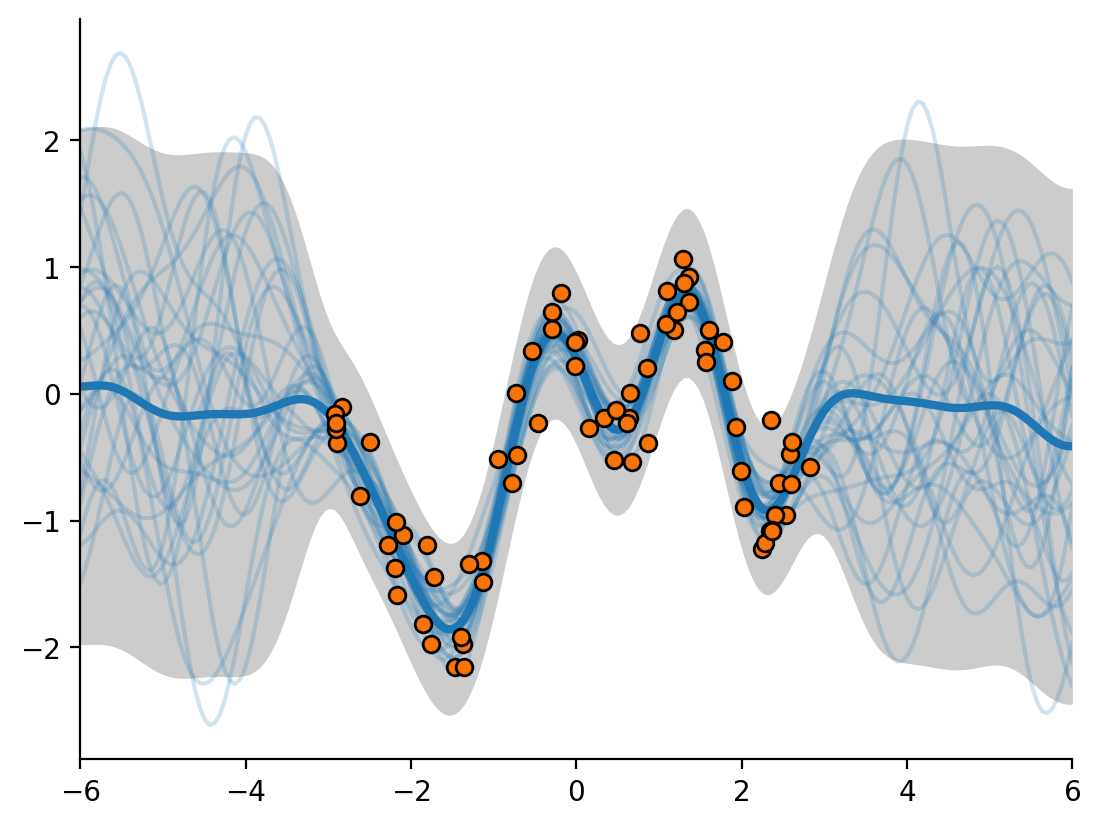

In [27]:
def bayesian_linear_regression(x, y, xt, K, sn2, sw2):
    X = build_fourier_features(x, K)
    w_posterior_mean, w_posterior_cov =  compute_posterior(X, y, sw2, sn2)
    # Inference
    Xt = build_fourier_features(xt, K)  
    y_mean, y_var =  compute_predictive(Xt, w_posterior_mean, w_posterior_cov, sn2)
    samples =  sample(Xt, w_posterior_mean, w_posterior_cov, sn2, N=30)
    return y_mean, y_var, samples


fig, ax = plt.subplots()

y_mean, y_var, samples = bayesian_linear_regression(x, y, xt, 100, sn2, sw2)

lb = y_mean - 2 * np.sqrt(y_var)
ub = y_mean + 2 * np.sqrt(y_var)

ax.fill_between(xt, lb, ub, color=".80", lw=0)
ax.plot(xt, samples.T, "tab:blue", alpha=0.2)
ax.plot(xt, y_mean, color="tab:blue", lw=3)
ax.scatter(x, y, edgecolor="black", linewidth=1, facecolor="xkcd:orange", zorder=10)
plt.show()

In [28]:
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive


def animate_random_features(K):
    fig, ax = plt.subplots()

    y_mean, y_var, samples = bayesian_linear_regression(x, y, xt, K, sn2, sw2)

    lb = y_mean - 2 * np.sqrt(y_var)
    ub = y_mean + 2 * np.sqrt(y_var)

    ax.fill_between(xt, lb, ub, color=".80", lw=0)
    ax.plot(xt, samples.T, "tab:blue", alpha=0.2)
    ax.plot(xt, y_mean, color="tab:blue", lw=3)
    ax.scatter(x, y, edgecolor="black", linewidth=1, facecolor="xkcd:orange", zorder=10)
    ax.set_ylim(-3, 3)
    plt.show()


interaction = interact(
    animate_random_features,
    K=widgets.IntSlider(min=1, max=500, step=10, value=10, continuous_update=False),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='K', max=500, min=1, step=10), …

## 7. A more complex model: being Bayesian on the noise (++)

Now we are ready spice things up! Everything we did, we did it assuming that the noise variance $\sigma_\mathrm{n}^2$ was known. This is a far too restrictive assumption in practice. 
There are several ways to choose $\sigma_\mathrm{n}^2$ (cross-validation, maximization of the marginal likelihood w.r.t. $\sigma_\mathrm{n}^2$, ...).
But this -- being a course on Bayesian inference -- requires to develop a solution in a "Bayesian" way: place a prior on $\sigma_\mathrm{n}^2$ and infer a posterior given some data.

As usual, the likelihood has the form $p(\mathbf{y}|\mathbf{w}, \mathbf{X}, \sigma_\mathrm{n}) = \mathcal{N}(\mathbf{X}\mathbf{w}, \sigma^2_\mathrm{n} \mathbf{I})$.

One can show that the natural conjugate prior is a normal-inverse Gaussian distribution with the following form:

\begin{align}
p(\mathbf{w}, \sigma^2_\mathrm{n})  &= \mathrm{NIG}(\mathbf{w}, \sigma^2_\mathrm{n}|\mu_0, \mathbf{\Sigma}_0, a_0, b_0) = \\
                                    &= \mathcal{N}(\mathbf{w}|\mu_0,\sigma^2_\mathrm{n}\mathbf{\Sigma}_0)\mathrm{IG}(\sigma^2_\mathrm{n}|a_0, b_0)
\end{align}

where IG is the inverse Gamma distribution.

**Exercise:** Since chances are you never saw an inverse Gamma distribution, use the following cell to play with it. Try to change the parameters $a_0$ and $b_0$. What happens if you both set them to 0?

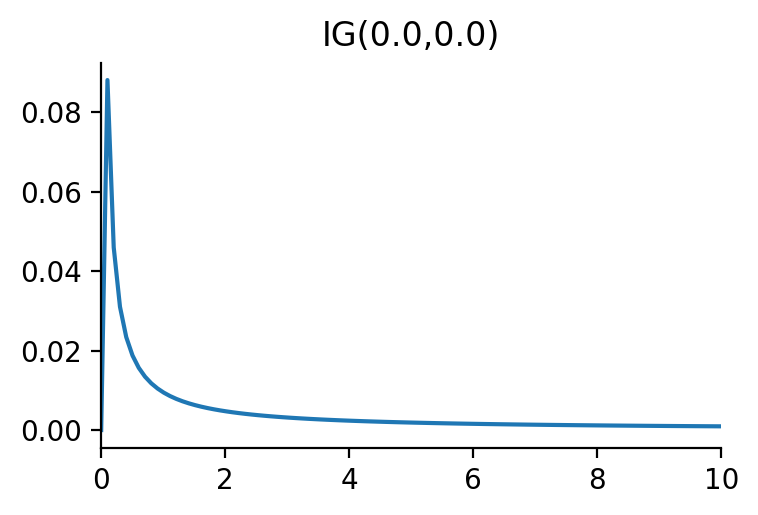

In [34]:
a0, b0 = 0.01, 0.01
rv = scipy.stats.invgamma(a=a0, scale=b0)

fig, ax = plt.subplots(figsize=[4, 2.5])
xplot = np.linspace(0, 10, 100)
ax.plot(xplot, rv.pdf(xplot))
ax.set_title("IG(%.1f,%.1f)" % (a0, b0))
plt.show()

**Comments**: Setting $a_0 = 0, b_0 = 0$, makes the IG distribution skewed, converging to a Dirac distribution centered on 0.

One can derive the posterior $p(\mathbf{w},\sigma_\mathrm{n}^2 | \mathbf{X}, \mathbf{y})$ as follows

\begin{align}
p(\mathbf{w},\sigma_\mathrm{n}^2 | \mathbf{X}, \mathbf{y}) &= \mathrm{NIG}(\mathbf{w},\sigma_\mathrm{n}^2|\mu, \mathbf{\Sigma}, a, b)\\
\mathbf{\Sigma} &= (\mathbf{\Sigma}_0^{-1} + \mathbf{X}^\top\mathbf{X})^{-1}\\
\mu &= \mathbf{\Sigma}(\mathbf{\Sigma}_0^{-1}\mu_0 + \mathbf{X}^\top\mathbf{y}) \\
a &= a_0 + n/2 \\ 
b &= b_0 + \frac{1}{2}(\mu_0^\top\mathbf{\Sigma}_0\mu_0 + \mathbf{y}^\top\mathbf{y} - \mu^\top\mathbf{\Sigma}\mu )
\end{align}

This is left as an exercise to the reader (joking aside if you want to know more check Sec. 7.6.3.1 of "Machine Learning: A probabilistic perspective" by K.P. Murphy).
From this formulation, you can derive the two marginals on $\mathbf{w}$ and ${\sigma_\mathrm{n}^2}$, which are easier to understand.

\begin{align}
p(\sigma_\mathrm{n}^2|\mathrm{X}, \mathrm{y}) &= \mathrm{IG}(a,b)\\
p(\mathbf{w}|\mathrm{X}, \mathrm{y}) &= \mathcal{T}\left(\mu, \frac{b}{a}\Sigma, 2a\right)
\end{align}

where $\mathcal{T}$ is a student-T distribution. 

Finally, the predictive distribution a new test points $\mathbf{X}_{\mathrm{new}}$ is again a student-T distribution with the following form, 

\begin{align}
p(\mathbf{y}_\mathrm{new}| \mathbf{X}_\mathrm{new}, \mathbf{X}, \mathbf{y}) = \mathcal{T}\left(\mathbf{X}_\mathrm{new}\mu, \frac{b}{a}(I + \mathbf{X}_\mathrm{new}\mathbf{\Sigma}\mathbf{X}_\mathrm{new}^\top), 2a \right)
\end{align}

**Exercise:** Write the function to compute the posterior following the formula above. Compute also the predictive posterior and plot few samples from it. 

For the prior, choose $\mu_0 = 0$, $\mathbf{\Sigma}_0 = \mathbf{I}$ and $a_0 = b_0 = 0$.

In [44]:
def compute_posterior(X, y, mu0, Sigma0, a0, b0):
    sigma0_inv = np.linalg.inv(Sigma0)
    sigma = np.linalg.inv(sigma0_inv + X.T @ X)
    mu = sigma @ (sigma0_inv @ mu0 + X.T@y)
    a = a0 + X.shape[0] / 2
    b = b0 + 0.5 * (mu0.T @ Sigma0 @ mu0 + y.T @ y - mu.T @ sigma @ mu)
    
    return  mu, sigma, a, b


def compute_predictive_posterior(X, mu, Sigma, a, b):
    m = X @ mu
    S = b * (np.eye(X.shape[0]) + X @ Sigma @ X.T) / a
    dof = 2*a
    return  m, S, dof


def sample_from_student_t(m, S, dof, n=1):
    d = len(m)
    if dof == np.inf:
        x = 1.0
    else:
        x = np.random.chisquare(dof, n) / dof
    z = np.random.multivariate_normal(np.zeros(d), S, (n,))
    return m + z / np.sqrt(x)[:, None]


def sample(Xt, w_mean, w_cov, w_dof, a, b, N):
    def _sample_single(Xt, w_mean, w_cov, w_dof, a, b):
        # @@ COMPLETE @@ #
        m, s, dof = compute_predictive_posterior(Xt, w_mean, w_cov, a, b)

        return sample_from_student_t(m, s, dof)

    samples = np.zeros((N, len(Xt)))
    for i in range(N):
        samples[i] = _sample_single(Xt, w_mean, w_cov, w_dof, a, b)
    return samples

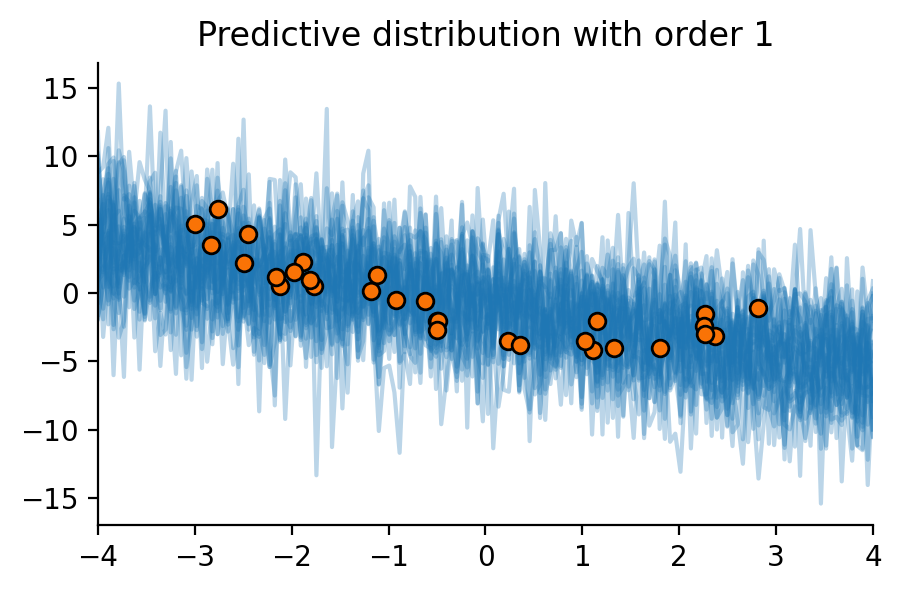

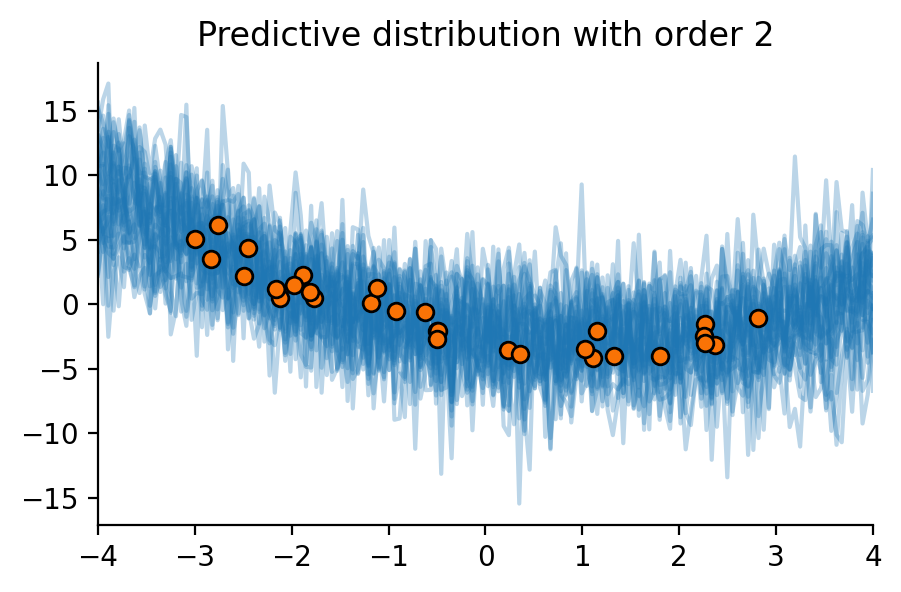

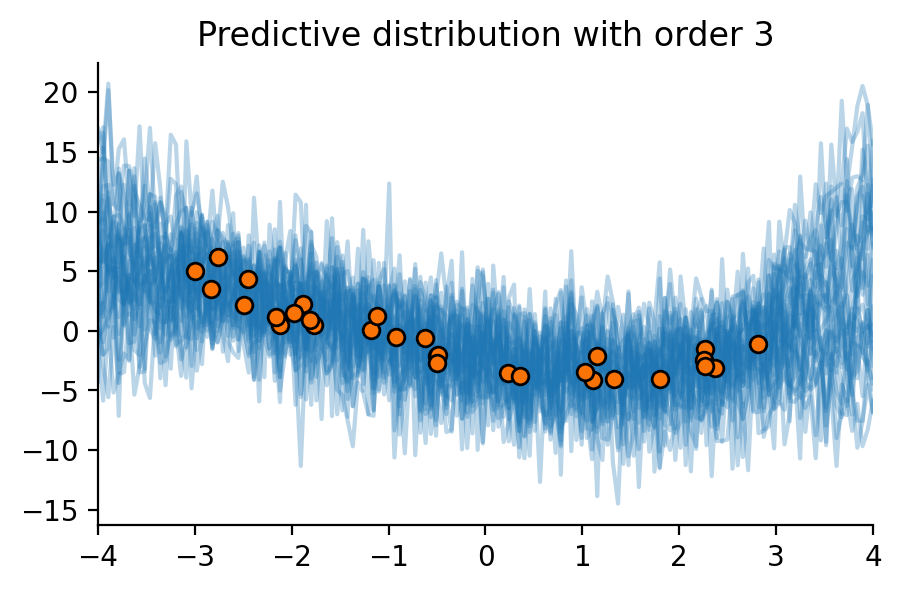

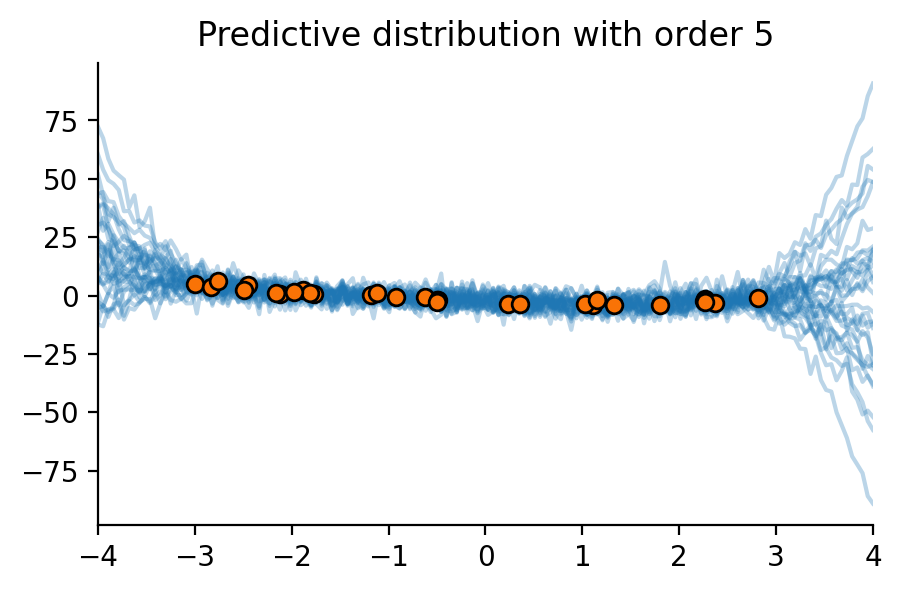

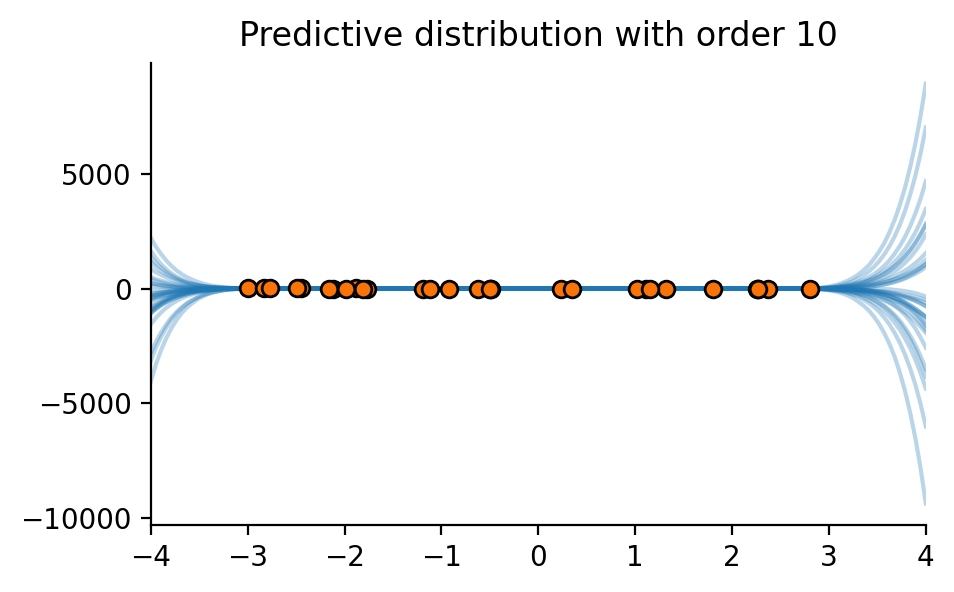

In [45]:
np.random.seed(1)
sn2 = 1.5
x, y = make_regression(30, sn2=sn2)
xt = np.linspace(-4, 4, 150)

for K in [1,2,3,5,10]:

    X = build_features(x, K)
    Xt = build_features(xt,K)

    # @@ COMPLETE @@ #
    mu0 = np.zeros(X.shape[1])
    Sigma0 = np.eye(Xt.shape[1])
    a0 = b0 = 0

    mu, Sigma, a, b =  compute_posterior(X, y, mu0, Sigma0, a0, b0)
    samples = sample(Xt, mu, Sigma, 2*a, a, b, N=30)

    fig, ax = plt.subplots(figsize=[5, 3])
    ax.scatter(x, y, edgecolor="black", linewidth=1, facecolor="xkcd:orange", zorder=10)
    ax.plot(xt, samples.T, "tab:blue", alpha=0.3)
    plt.title(f"Predictive distribution with order {K}")
    plt.show()

**Question:** Compare this plot with the previous one with order 1. Do you see any difference? Comment the results.

**Exercise:** Do the same a before, but now with order 2, 3, 5 and 10.